In [67]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

# do not show warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# load experiment
e = exp.load('iter_exps01', experiment_location='experiments', datadir='Mdata')
e.trials_df

,trial_idx,model_name,expt,name,trial,mean_LLs
0,0,tconv_scaffold_iter,expt04,tconv_scaffold_iter0,<experiment.Trial object at 0x7f9b55eb8e50>,0.451034
0,1,tconv_scaffold_iter,expt04,tconv_scaffold_iter1,<experiment.Trial object at 0x7f9b55d50640>,0.468762
0,10,tconv_scaffold_iter,expt04,tconv_scaffold_iter10,<experiment.Trial object at 0x7f9b55ec56d0>,0.438648
0,2,tconv_scaffold_iter,expt04,tconv_scaffold_iter2,<experiment.Trial object at 0x7f9b559a0f40>,0.466018
0,3,tconv_scaffold_iter,expt04,tconv_scaffold_iter3,<experiment.Trial object at 0x7f9b565d30d0>,0.472624
0,4,tconv_scaffold_iter,expt04,tconv_scaffold_iter4,<experiment.Trial object at 0x7f9b55a20640>,0.458199
0,5,tconv_scaffold_iter,expt04,tconv_scaffold_iter5,<experiment.Trial object at 0x7f9b56489af0>,0.428332
0,6,tconv_scaffold_iter,expt04,tconv_scaffold_iter6,<experiment.Trial object at 0x7f9b5570f430>,0.456097
0,7,tconv_scaffold_iter,expt04,tconv_scaffold_iter7,<experiment.Trial object at 0x7f9b559a02b0>,0.446580
0,8,tconv_scaffold_iter,expt04,tconv_scaffold_iter8,<experiment.Trial object at 0x7f9b55c28490>,0.449833


In [72]:
# # print the parameters of the models
# for trial in e.trials:
#     print('=== Trial: ', trial.name, ' ===')
#     print(trial.model.print_params(key='reg_vals'))

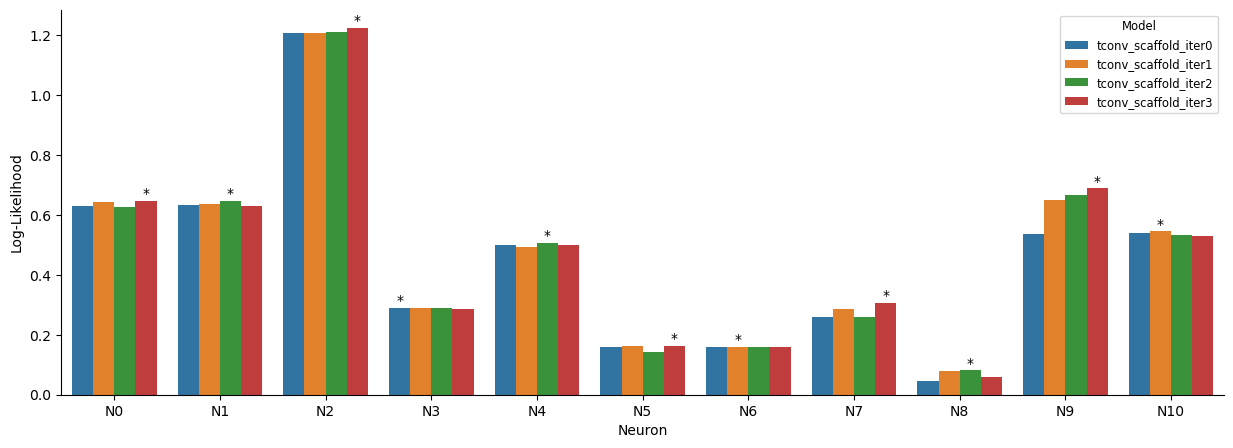

In [73]:
e.plot_LLs()

In [49]:
e.trials_where(trial_idx=0)[0].model.NDN.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([231, 8])
  Layer 1:
      weight: torch.Size([176, 8])
Network 1:
  Layer 0:
      weight: torch.Size([1152, 11])
      bias: torch.Size([11])


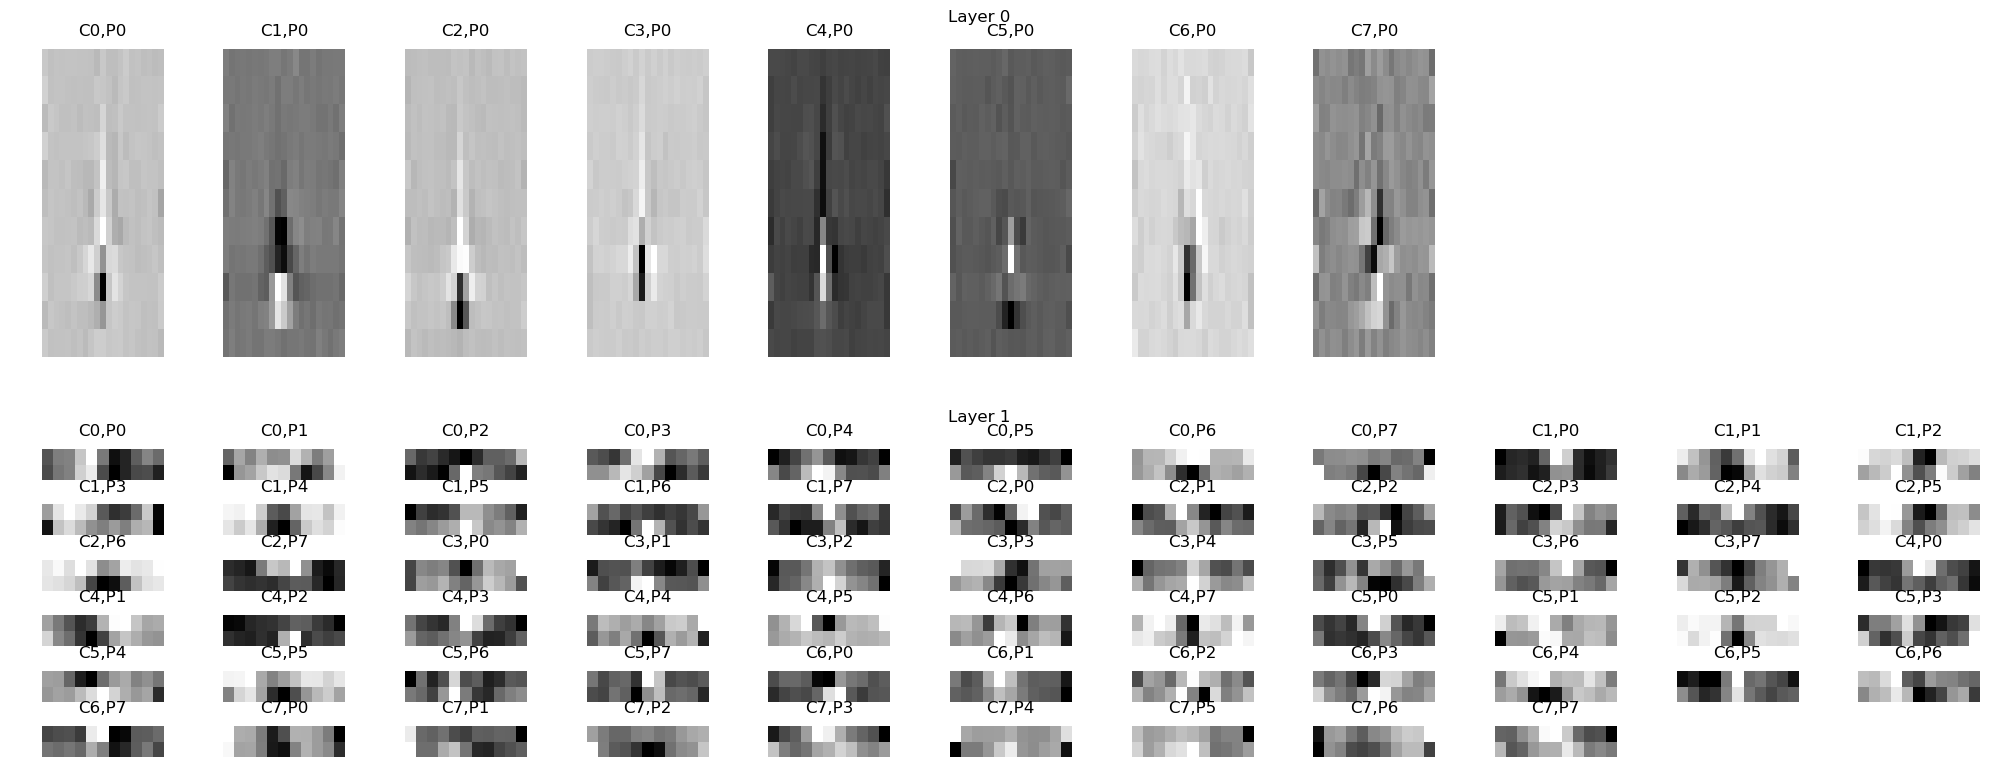

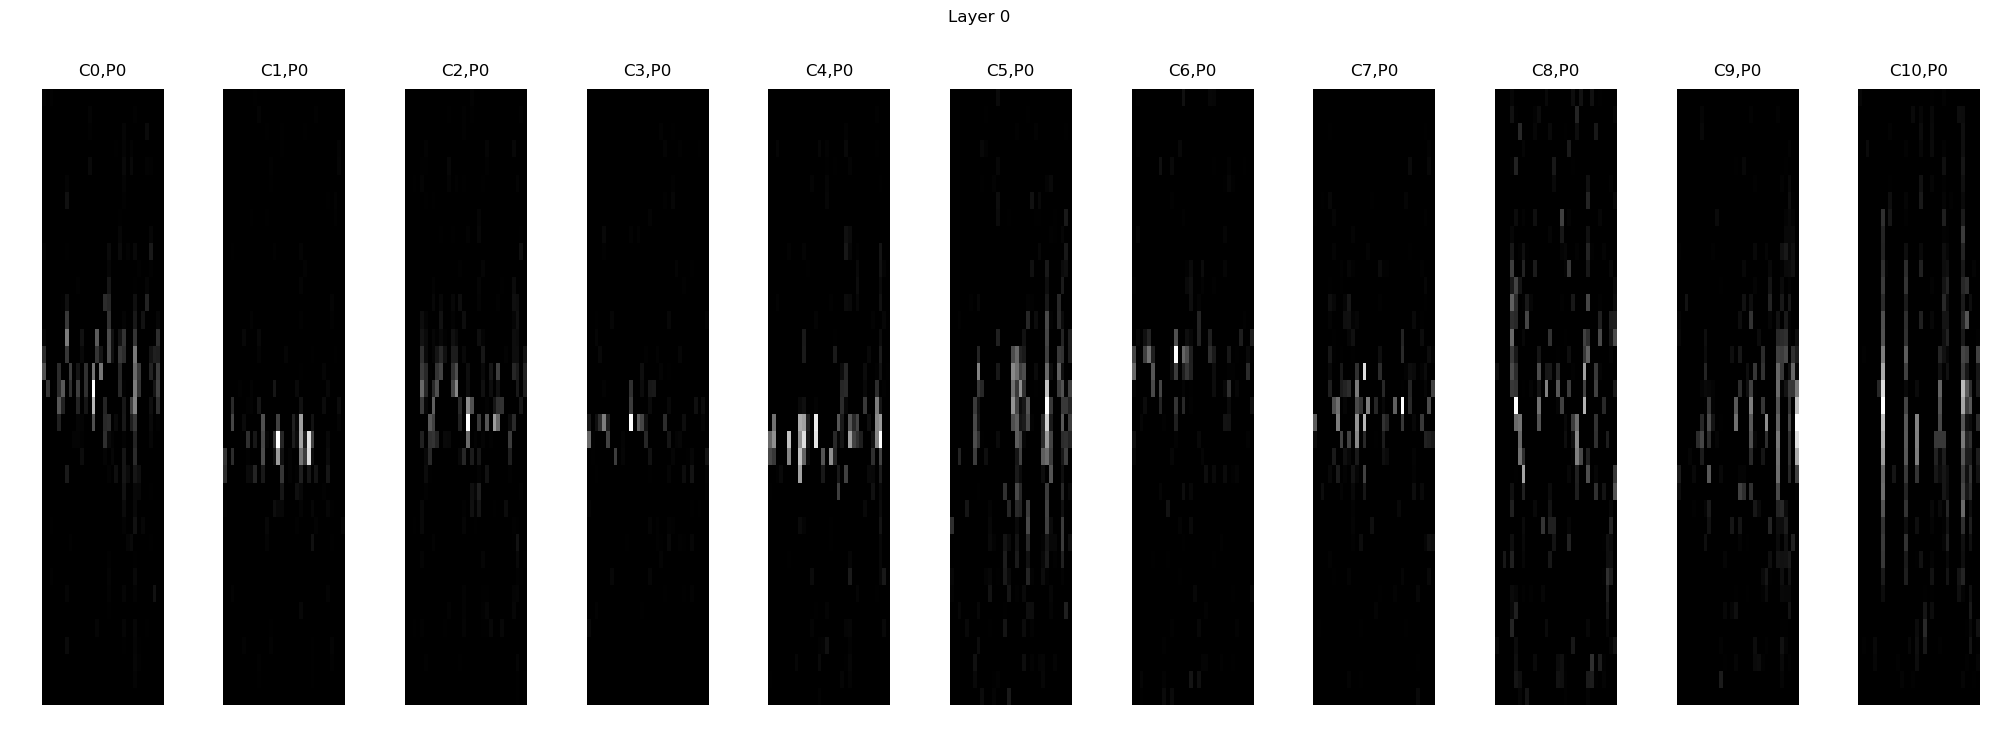

In [48]:
plot.plot_model_weights(e.trials_where(trial_idx=0)[0].model, max_cols=11, figsize=(25,8))

In [61]:
# filter_width=(17,7) num_subunits=(12,12), num_iter=3  
# 17x14 x 12 --> 7x12 x 12 --> 36*12 + 36*12*3

# 21x10 x 10 --> 36x10x3
model = e.trials_where(trial_idx=5)[0].model
model.NDN.list_parameters()
model.networks[0].layers[0].weights.shape, model.networks[1].layers[0].weights.shape

Network 0:
  Layer 0:
      weight: torch.Size([210, 10])
Network 1:
  Layer 0:
      weight: torch.Size([1800, 11])
      bias: torch.Size([11])


((21, 10, 10), (50, 36, 11))

max:  0.17548232 min:  -0.17548232


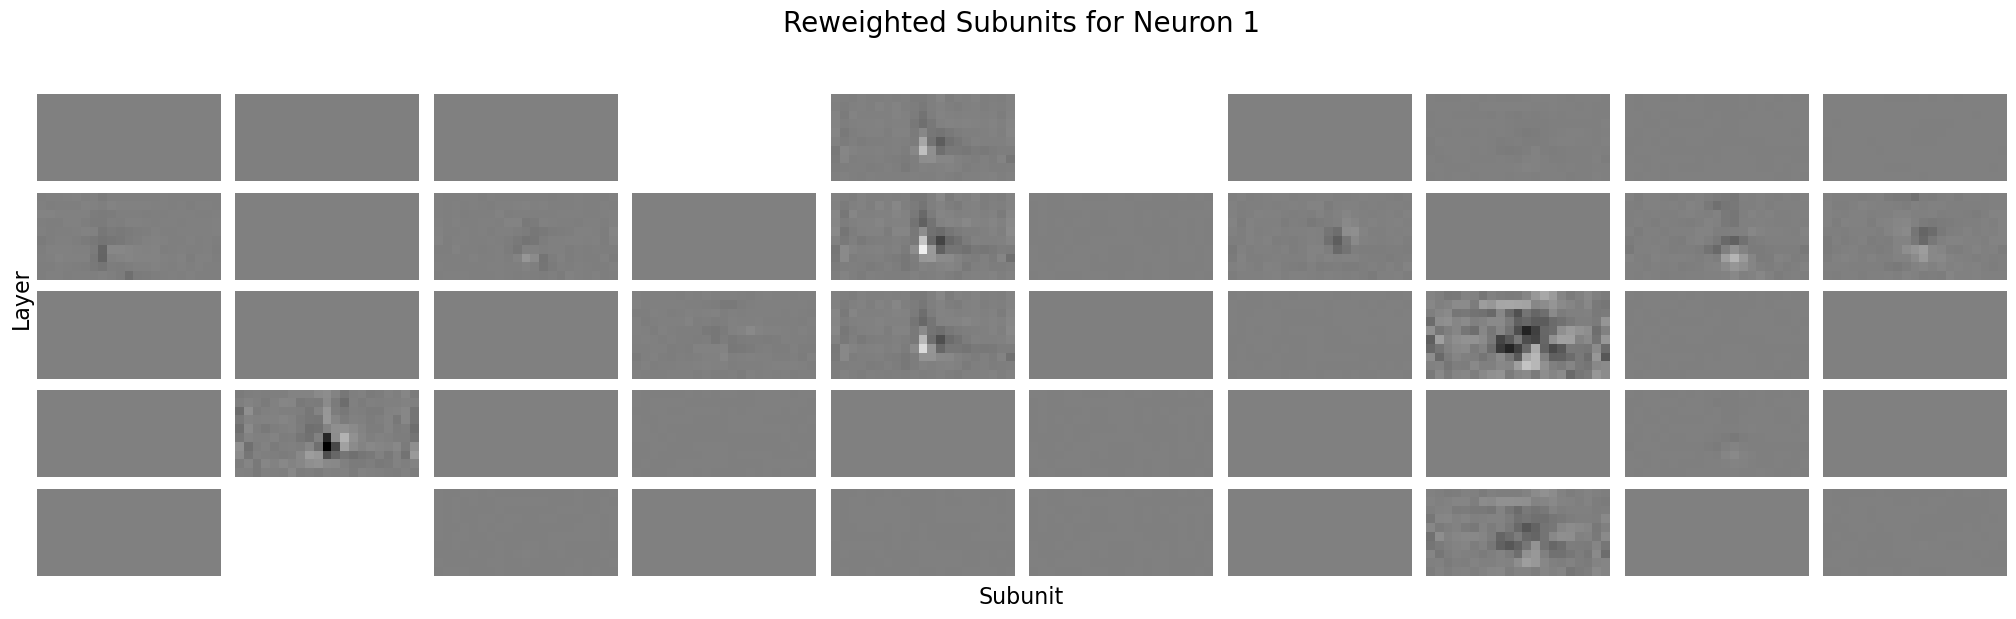

In [107]:
# reweight the subunits by their connection to the readout layer
# get the readout layer weights
readout_weights = model.networks[1].layers[0].weights
# get the subunit weights
subunit_weights = model.networks[0].layers[0].weights

# swap the last and first axes of the subunit weights
subunit_weights = np.swapaxes(subunit_weights, 0, 2)

# reweight the subunits
reweighteds = [] # layer, neuron, subunit
for neuron in range(11):
    reweighted_layer = []
    for layer in range(5):
        reweighted_neuron = []
        for i,readout_weight in enumerate(readout_weights[20:30,15,neuron]):
            reweighted = readout_weight * subunit_weights[i,:,:]
            reweighted_neuron.append(reweighted)
        reweighted_layer.append(reweighted_neuron)
    reweighteds.append(reweighted_layer)

# get the min and max of the reweighted subunits
imax = np.max(reweighteds)
imin = -imax
print('max: ', imax, 'min: ', imin)

# plot the reweighted subunits for neuron 1
fig, axs = plt.subplots(5,10, figsize=(20,6))
for layer in range(5):
    for i,reweighted in enumerate(reweighteds[layer][1]):
        ax = axs[layer,i]
        ax.imshow(reweighted, cmap='gray', origin='lower', vmin=imin, vmax=imax)
        ax.axis('off')
plt.tight_layout()
plt.suptitle('Reweighted Subunits for Neuron 1', fontsize=20)
# put spacing between the title and the subplots
plt.subplots_adjust(top=0.85)
# label the super axes large font
fig.text(0.5, 0, 'Subunit', ha='center', va='center', fontsize=16)
fig.text(0, 0.5, 'Layer', ha='center', va='center', rotation='vertical', fontsize=16)
plt.show()

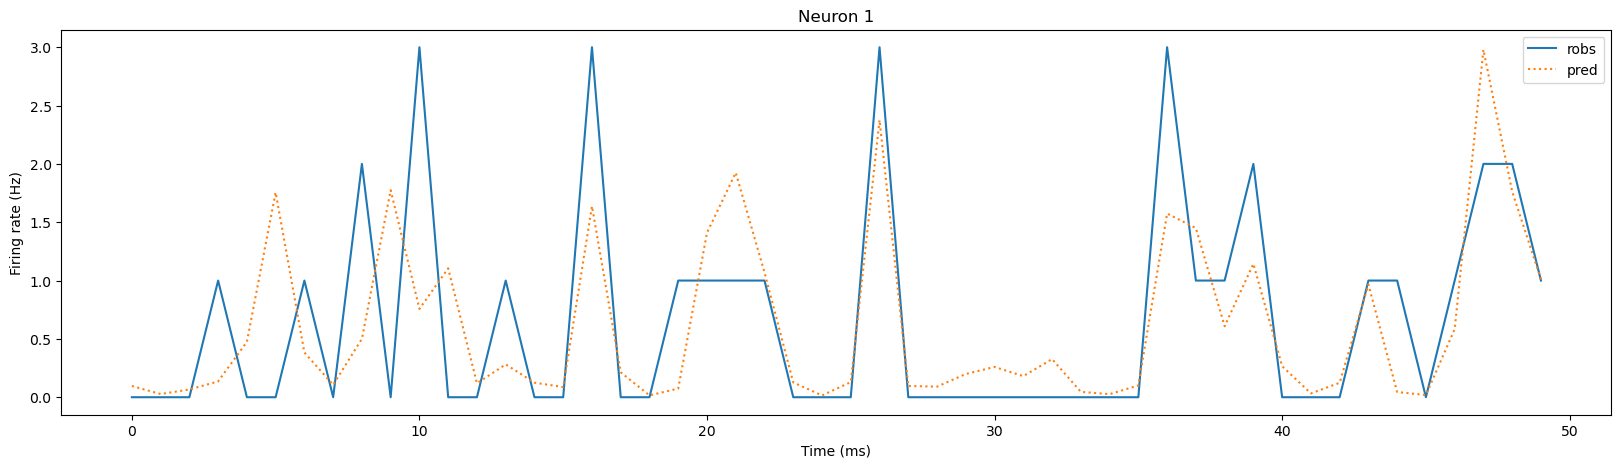

In [92]:
results = predict.predict(e.trials_where(trial_idx=5)[0].model, dataset=e.trials_where(trial_idx=5)[0].dataset[100:150])

# plot the results
plot.plot_robs(results.robs, results.pred, neuron=1, figsize=(20,5))